In [23]:
import numpy as np  # For numerical operations and array manipulations
import torch  # Core PyTorch library for tensor operations
import torch.nn as nn  # For building neural network layers
import torch.nn.functional as F  # For functional operations like activation functions, loss, etc.
import matplotlib.pyplot as plt  # For visualizing data and results (e.g., PSFs)
import pyzdde.zdde as pyz  # For communicating with Zemax via DDE interface
import os  # For file and path manipulations
from omegaconf import OmegaConf  # For loading and managing YAML/structured configuration files

In [24]:
# Load dataset configuration YAML file as an OmegaConf object
dataset_config = OmegaConf.load('../dataset_config.yaml')

# Load model configuration YAML file as an OmegaConf object
model_config = OmegaConf.load('../model_config.yaml')

# Merge both dataset and model configurations into a single config object
config = OmegaConf.merge(dataset_config, model_config)


In [25]:
# Create a DDE link object to communicate with Zemax via PyZDDE
ln = pyz.createLink()

# Construct the full file path to the Zemax lens file using the config
zfile = os.path.join(ln.zGetPath()[1], 'Sequential', 'Objectives', config['zemax']['lens_file_path'])

# Load the Zemax lens file into the DDE session
ln.zLoadFile(zfile)


0

In [26]:
# Modify FFT PSF settings in Zemax using parameters from the config file
# - settingsFile: path to the configuration file specifying FFT PSF parameters
# - sample: image sampling factor (e.g., 1 for 64x64, 2 for 128x128, etc.)
# Other parameters like dtype, wave, field, etc., use default (None)

ln.zModifyFFTPSFSettings(
    settingsFile = config['zemax']['config_file_path'],
    dtype        = None,
    sample       = config['zemax']['sampling'],
    wave         = None,
    field        = None,
    surf         = None,
    pol          = None,
    norm         = None,
    imgDelta     = None
)


(0,)

In [27]:
def extract_parameters(config):
    # Initialize lists for categorized parameters
    to_predict = []           # Parameters with training ranges
    untrained_predict = []    # Parameters with unseen test-time ranges
    not_to_predict = []       # Parameters with fixed static values

    # Iterate over all primary mirror segments
    for segment in config["primary_mirror"]["segments"]:
        seg_id = segment["id"]
        for param in ["piston", "tip", "tilt"]:
            param_config = segment[param]                    # Access parameter config (dict with 'range', 'static', etc.)
            param_name = f"primary_{seg_id}_{param}"         # Generate full parameter name (e.g., "primary_1_piston")

            # Classify parameter based on configuration keys
            if "range" in param_config:
                to_predict.append(param_name)                # Used for model training
            elif "untrained_range" in param_config:
                untrained_predict.append(param_name)         # Seen only during testing, for generalization check
            elif "static" in param_config:
                not_to_predict.append(param_name)            # Fixed value, excluded from model training

    # Handle secondary mirror parameters
    for param in ["piston", "tip", "tilt"]:
        param_config = config["secondary_mirror"][param]
        param_name = f"secondary_{param}"

        if "range" in param_config:
            to_predict.append(param_name)
        elif "untrained_range" in param_config:
            untrained_predict.append(param_name)
        elif "static" in param_config:
            not_to_predict.append(param_name)

    # Return all categorized parameter lists
    return to_predict, untrained_predict, not_to_predict


In [28]:
to_predict, untrained_predict, not_to_predict = extract_parameters(config)
to_predict

['primary_1_piston', 'primary_2_piston', 'primary_3_piston']

In [29]:
class ResNetRegression(nn.Module):
    def __init__(self, config, num_outputs):
        super(ResNetRegression, self).__init__()

        # Store config and determine if phase magnitude input is used
        self.cfg = config["model"]
        self.use_phase_mag = config["dataset"]["use_phase_mag"]
        self.merge_strategy = self.cfg["add_magnitude_ann"]["merge_strategy"] if self.use_phase_mag else None

        # Determine image size and input channels from Zemax sampling and defocus usage
        zemax_sampling = config["zemax"]["sampling"]
        self.image_size = 64 * zemax_sampling
        self.input_channels = 2 if config["dataset"]["use_defocus"] else 1
        self.output_dim = num_outputs

        # Create convolutional layers from YAML configuration
        self.conv_layers = nn.ModuleList()
        in_channels = self.input_channels
        for layer_cfg in self.cfg["conv_layers"]:
            out_channels = layer_cfg["out_channels"]
            kernel_size = layer_cfg["kernel_size"]
            padding = kernel_size // 2
            activation = layer_cfg.get("activation", True)

            block = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False)]
            if activation:
                block.append(nn.ReLU())
            if layer_cfg["pooling"]:
                block.append(nn.MaxPool2d(kernel_size=2, stride=2))

            self.conv_layers.append(nn.Sequential(*block))
            in_channels = out_channels

        # Build skip connection operations based on type ("conv+pool" or "add")
        self.skip_connections = self.cfg["skip_connections"]
        self.skip_ops = nn.ModuleDict()
        for skip in self.skip_connections:
            from_layer = skip["from_layer"]
            to_layer = skip["to_layer"]
            skip_type = skip["type"]
            in_ch = self.cfg["conv_layers"][from_layer]["out_channels"]
            out_ch = self.cfg["conv_layers"][to_layer]["out_channels"]

            if skip_type == "conv+pool":
                self.skip_ops[f"{from_layer}->{to_layer}"] = nn.Sequential(
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
                )
            elif skip_type == "add":
                self.skip_ops[f"{from_layer}->{to_layer}"] = nn.Identity()

        # Calculate flattened feature map size after all pooling layers
        pool_count = sum(1 for l in self.cfg["conv_layers"] if l["pooling"])
        spatial_dim = self.image_size // (2 ** pool_count)
        final_out_channels = self.cfg["conv_layers"][-1]["out_channels"]
        flatten_dim = final_out_channels * spatial_dim * spatial_dim

        # Fully connected layers for CNN branch
        self.fc_layers = nn.ModuleList()
        in_dim = flatten_dim
        for dim in self.cfg["fc_layers"]:
            self.fc_layers.append(nn.Linear(in_dim, dim))
            in_dim = dim
        self.final_cnn_out_dim = in_dim

        # Fully connected ANN branch for phase magnitude (if enabled)
        if self.use_phase_mag:
            ann_hidden = self.cfg["add_magnitude_ann"]["hidden_layers"]
            self.ann_layers = nn.ModuleList()

            # Input is phase magnitude row + col (nominal + defocus if used)
            ann_in_dim = self.image_size * 2
            if config["dataset"]["use_defocus"]:
                ann_in_dim *= 2

            for dim in ann_hidden:
                self.ann_layers.append(nn.Linear(ann_in_dim, dim))
                ann_in_dim = dim
            self.ann_out_dim = ann_in_dim

            # Merge CNN and ANN outputs depending on strategy
            if self.merge_strategy == "concat":
                merged_dim = self.final_cnn_out_dim + self.ann_out_dim
            elif self.merge_strategy == "add":
                assert self.final_cnn_out_dim == self.ann_out_dim, "Merge='add' requires ANN and CNN dims to match"
                merged_dim = self.final_cnn_out_dim

            # Final prediction layer after merging
            self.fc_out = nn.Linear(merged_dim, self.output_dim)
        else:
            # Final prediction layer if no ANN branch
            self.fc_out = nn.Linear(self.final_cnn_out_dim, self.output_dim)

    def forward(self, *inputs):
        # Separate inputs if phase magnitude is used
        if self.use_phase_mag:
            x, magnitude_tensors = inputs
        else:
            x = inputs[0]

        outputs = []
        # Forward pass through convolutional layers with skip connections
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            outputs.append(x)

            # Apply any skip connections targeting current layer
            for skip in self.skip_connections:
                if skip["to_layer"] == i:
                    from_layer = skip["from_layer"]
                    key = f"{from_layer}->{i}"
                    skip_out = self.skip_ops[key](outputs[from_layer])
                    x = x + skip_out
                    outputs[i] = x

        # Flatten feature map and apply FC layers (CNN branch)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        for fc in self.fc_layers:
            x = F.relu(fc(x))

        # ANN forward pass (if used)
        if self.use_phase_mag:
            ann = magnitude_tensors.view(magnitude_tensors.size(0), -1)
            for layer in self.ann_layers:
                ann = F.relu(layer(ann))

            # Merge CNN and ANN outputs
            if self.merge_strategy == "concat":
                x = torch.cat([x, ann], dim=1)
            elif self.merge_strategy == "add":
                x = x + ann

        # Final regression output
        return self.fc_out(x)


In [31]:
def plot_images(images, titles, cmap='inferno'):
    """Helper function to plot a list of images with titles in multiple rows of 3 columns each."""
    num_images = len(images)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

    # Flatten axes for consistent indexing, even if there's only 1 row
    axes = axes.flatten() if num_rows > 1 or num_cols > 1 else [axes]

    for idx in range(num_rows * num_cols):
        ax = axes[idx]
        if idx < num_images:
            ax.imshow(images[idx], cmap=cmap)
            ax.set_title(titles[idx])
            ax.axis('off')
        else:
            ax.axis('off')  # Hide any unused subplots

    plt.tight_layout()
    plt.show()


In [32]:
def apply_mirror_alignment(
    primary_segment_1_piston, primary_segment_1_tip, primary_segment_1_tilt,
    primary_segment_2_piston, primary_segment_2_tip, primary_segment_2_tilt,
    primary_segment_3_piston, primary_segment_3_tip, primary_segment_3_tilt,
    primary_segment_4_piston, primary_segment_4_tip, primary_segment_4_tilt,
    primary_segment_5_piston, primary_segment_5_tip, primary_segment_5_tilt,
    primary_segment_6_piston, primary_segment_6_tip, primary_segment_6_tilt,
    secondary_mirror_piston, secondary_mirror_tip, secondary_mirror_tilt,
):
    """
    Applies mirror misalignments for primary (NSC) and secondary (Sequential) mirrors.
    Returns the generated PSF array.
    """
    wavelength = 0.632  # microns

    segment_values = [
        (primary_segment_1_piston, primary_segment_1_tip, primary_segment_1_tilt),
        (primary_segment_2_piston, primary_segment_2_tip, primary_segment_2_tilt),
        (primary_segment_3_piston, primary_segment_3_tip, primary_segment_3_tilt),
        (primary_segment_4_piston, primary_segment_4_tip, primary_segment_4_tilt),
        (primary_segment_5_piston, primary_segment_5_tip, primary_segment_5_tilt),
        (primary_segment_6_piston, primary_segment_6_tip, primary_segment_6_tilt),
    ]

    # --- Primary mirror segments (inside NSC group) ---
    for seg_idx, (piston_lambda, tip_lambda, tilt_lambda) in enumerate(segment_values):
        piston_mm = (piston_lambda / 1000) * wavelength
        tip_deg = np.degrees(np.arctan((wavelength * tip_lambda) / 125180))
        tilt_deg = np.degrees(np.arctan((wavelength * tilt_lambda) / 125180))

        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=3, data=float(piston_mm))  # Z
        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=4, data=float(tip_deg))    # Tilt-X
        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=5, data=float(tilt_deg))   # Tilt-Y

    # --- Secondary mirror (sequential surface) ---
    sec_piston_mm = (secondary_mirror_piston / 1000) * wavelength
    sec_tip_deg = np.degrees(np.arctan((wavelength * secondary_mirror_tip) / 61000))
    sec_tilt_deg = np.degrees(np.arctan((wavelength * secondary_mirror_tilt) / 61000))

    ln.zSetThickness(surfNum=6, value=float(sec_piston_mm))  # Thickness is like Z piston
    ln.zSetSurfaceParameter(surfNum=6, param=3, value=float(sec_tip_deg))  # Tilt-X
    ln.zSetSurfaceParameter(surfNum=6, param=4, value=float(sec_tilt_deg))  # Tilt-Y

    # --- Get PSF ---
    psf_list = ln.zGetPSF('fft')[1]
    psf_array = np.array(psf_list)

    return psf_array


In [33]:
def apply_from_dict(param_dict):
    return apply_mirror_alignment(
        param_dict["primary_1_piston"], param_dict["primary_1_tip"], param_dict["primary_1_tilt"],
        param_dict["primary_2_piston"], param_dict["primary_2_tip"], param_dict["primary_2_tilt"],
        param_dict["primary_3_piston"], param_dict["primary_3_tip"], param_dict["primary_3_tilt"],
        param_dict["primary_4_piston"], param_dict["primary_4_tip"], param_dict["primary_4_tilt"],
        param_dict["primary_5_piston"], param_dict["primary_5_tip"], param_dict["primary_5_tilt"],
        param_dict["primary_6_piston"], param_dict["primary_6_tip"], param_dict["primary_6_tilt"],
        param_dict["secondary_piston"], param_dict["secondary_tip"], param_dict["secondary_tilt"]
    )

In [34]:
# Load model
model = ResNetRegression(num_outputs=len(to_predict), config =config)
model.load_state_dict(torch.load(f"./{config['model']['name']}.pth", map_location="cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [35]:
print(model)

ResNetRegression(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (skip_ops): ModuleDict(
    (0->2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [76]:
def predict_ptt_from_model(model, ln, config, input_dict, device, dataset_transform="sqrt"):
    # Step 1: Extract parameter names
    to_predict, untrained_predict, not_to_predict_list = extract_parameters(config)

    # Step 2: Build parameter sets for to_predict and untrained parameters
    to_predict_param = {name: input_dict[name] for name in to_predict}
    untrained_param = {name: input_dict[name] for name in untrained_predict}

    # Step 3: Populate static parameters for "not_to_predict"
    not_to_predict = {}
    for name in not_to_predict_list:
        if "primary" in name:
            seg_id, param = name.split("_")[1], name.split("_")[2]
            for segment in config["primary_mirror"]["segments"]:
                if str(segment["id"]) == seg_id:
                    not_to_predict[name] = float(segment[param]["static"])
        elif "secondary" in name:
            param = name.split("_")[1]
            not_to_predict[name] = float(config["secondary_mirror"][param]["static"])

    # Step 4: Combine all parameter sets into full_param
    full_param = {**to_predict_param, **untrained_param, **not_to_predict}

    # Step 5: Generate Actual PSFs (Nominal and Defocused)
    psf_nominal = apply_from_dict(full_param)  # Apply nominal PSF
    global_defocus = config["global_defocus"]
    psf_defocus = None
    if global_defocus != 0:  # If defocus is applied
        defocus_param = full_param.copy()
        defocus_param["secondary_piston"] += global_defocus
        psf_defocus = apply_from_dict(defocus_param)

    # Step 6: Transform PSF images based on specified transformation type
    def transform(img):
        if dataset_transform == "sqrt":  # Apply square root transformation
            return np.sqrt(img)
        elif dataset_transform == "log":  # Apply logarithmic transformation
            return np.log(img + 1e-6)
        else:
            raise ValueError(f"Unknown transform type: {dataset_transform}")

    psf_nominal_transformed = transform(psf_nominal)
    psf_defocus_transformed = transform(psf_defocus) if psf_defocus is not None else None

    # Step 7: Prepare input tensor for the model
    input_tensor = torch.from_numpy(
        np.stack([psf_nominal_transformed, psf_defocus_transformed])
        if psf_defocus_transformed is not None else
        np.expand_dims(psf_nominal_transformed, axis=0)
    ).unsqueeze(0).float().to(device)

    # Step 8: Prepare phase magnitude features (if needed)
    use_phase_mag = config["dataset"]["use_phase_mag"]
    use_defocus = config["dataset"]["use_defocus"]

    if use_phase_mag:
        row_col_features = []  # List to store row and column features
        for psf in [psf_nominal_transformed, psf_defocus_transformed] if use_defocus else [psf_nominal_transformed]:
            fft_result = np.fft.fft2(psf)  # Apply FFT to extract magnitude
            fft_shift_result = np.fft.fftshift(psf)
            magnitude = np.abs(fft_shift_result)
            h, w = magnitude.shape
            mid_row = magnitude[h // 2, :]  # Middle row of the magnitude
            mid_row_norm = (mid_row - np.min(mid_row))/(np.max(mid_row) - np.min(mid_row))
            mid_col = magnitude[:, w // 2]  # Middle column of the magnitude
            mid_col_norm = (mid_col - np.min(mid_col))/(np.max(mid_col) - np.min(mid_col))
            row_col_features.extend([mid_row_norm, mid_col_norm])  # Append to feature list

        magnitude_features = np.concatenate(row_col_features, axis=0)
        magnitude_features = torch.tensor(magnitude_features).float().unsqueeze(0).to(device)
        input_tensor = (input_tensor, magnitude_features)  # Combine PSF and magnitude features
    else:
        input_tensor = (input_tensor,)  # Only use PSF image if no phase magnitude

    # Step 9: Model prediction
    model.eval()
    with torch.no_grad():  # Disable gradient computation
        prediction = model(*input_tensor) if use_phase_mag else model(input_tensor[0])

    # Step 10: Extract predicted parameters and calculate RMSE
    predicted_param = {name: prediction[0, i].item() for i, name in enumerate(to_predict)}
    rmse = np.sqrt(np.mean([(full_param[name] - predicted_param[name]) ** 2 for name in to_predict]))  # RMSE Calculation

    # Step 11: Print predictions for each parameter
    print("\nPrediction:")
    for name in to_predict:
        print(f"    {name}: {full_param[name]:.4f} → {predicted_param[name]:.4f}")

    print(f"\nRMSE: {rmse:.4f}")  # Print RMSE value
    
    # Step 12: Print static parameters (not trained)
    print("\nStatic Parameters:")
    if not not_to_predict:
        print("    None")
    else:
        for name in not_to_predict:
            print(f"    {name}: {not_to_predict[name]:.4f}")

    # Step 13: Print untrained parameters (kept constant)
    print("\nUntrained Parameters (kept constant):")
    if not untrained_param:
        print("    None")
    else:
        for name in untrained_param:
            print(f"    {name}: {untrained_param[name]:.4f}")
    print()

    # Step 14: Generate predicted PSFs
    predicted_full_param = {**predicted_param, **untrained_param, **not_to_predict}
    predicted_nominal_psf = apply_from_dict(predicted_full_param)
    predicted_defocus_psf = None
    if global_defocus != 0:
        predicted_defocus_param = predicted_full_param.copy()
        predicted_defocus_param["secondary_piston"] += global_defocus
        predicted_defocus_psf = apply_from_dict(predicted_defocus_param)

    # Step 15: Visualize PSFs and Pixel-wise Differences
    if use_defocus:
        plt.figure(figsize=(14, 10))
        plt.subplot(3, 2, 1)
        plt.imshow(psf_nominal, cmap='gray')
        plt.title("Actual Nominal PSF")
        plt.colorbar()

        plt.subplot(3, 2, 2)
        plt.imshow(psf_defocus, cmap='gray')
        plt.title("Actual Defocused PSF")
        plt.colorbar()

        plt.subplot(3, 2, 3)
        plt.imshow(predicted_nominal_psf, cmap='gray')
        plt.title("Predicted Nominal PSF")
        plt.colorbar()

        plt.subplot(3, 2, 4)
        plt.imshow(predicted_defocus_psf, cmap='gray')
        plt.title("Predicted Defocused PSF")
        plt.colorbar()

        plt.subplot(3, 2, 5)
        plt.imshow(psf_nominal - predicted_nominal_psf, cmap='gray')
        plt.title("Pixel-wise Diff (Nominal)")
        plt.colorbar()

        plt.subplot(3, 2, 6)
        plt.imshow(psf_defocus - predicted_defocus_psf, cmap='gray')
        plt.title("Pixel-wise Diff (Defocus)")
        plt.colorbar()

        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(psf_nominal, cmap='gray')
        plt.title("Actual Nominal PSF")
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.imshow(predicted_nominal_psf, cmap='gray')
        plt.title("Predicted Nominal PSF")
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.imshow(psf_nominal - predicted_nominal_psf, cmap='gray')
        plt.title("Pixel-wise Diff (Nominal)")
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    # Step 16: Plot phase magnitude differences if needed
    if use_phase_mag:
        def plot_row_col_features_diff(img1, img2, title_prefix):
            fft1 = np.fft.fft2(img1)
            fft_shifted1 = np.fft.fftshift(fft1)
            fft2 = np.fft.fft2(img2)
            fft_shifted2 = np.fft.fftshift(fft2)
            mag1 = np.abs(fft_shifted1)
            mag2 = np.abs(fft_shifted2)

            h, w = mag1.shape
            row1, col1 = mag1[h // 2, :], mag1[:, w // 2]
            row2, col2 = mag2[h // 2, :], mag2[:, w // 2]

            row1_norm = (row1 - np.min(row1))/(np.max(row1) - np.min(row1))
            col1_norm = (col1 - np.min(col1))/(np.max(col1) - np.min(col1))
            row2_norm = (row2 - np.min(row2))/(np.max(row2) - np.min(row2))
            col2_norm = (col2 - np.min(col2))/(np.max(col2) - np.min(col2))

            row_diff = row1_norm - row2_norm
            col_diff = col1_norm - col2_norm

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.plot(row1_norm, label='Actual')
            plt.plot(row2_norm, label='Predicted')
            plt.title(f"{title_prefix} - Mid Row")
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.plot(col1_norm, label='Actual')
            plt.plot(col2_norm, label='Predicted')
            plt.title(f"{title_prefix} - Mid Column")
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.plot(row_diff, label='Row Diff')
            plt.plot(col_diff, label='Col Diff')
            plt.title(f"{title_prefix} - Diff")
            plt.legend()

            plt.tight_layout()
            plt.show()

        # Plot nominal features
        pred_nominal_trans = transform(predicted_nominal_psf)
        plot_row_col_features_diff(psf_nominal_transformed, pred_nominal_trans, "Nominal")

        # Plot defocus features if available
        if use_defocus and predicted_defocus_psf is not None:
            pred_defocus_trans = transform(predicted_defocus_psf)
            plot_row_col_features_diff(psf_defocus_transformed, pred_defocus_trans, "Defocused")

        # Step 17: Create corrected input_dict with updated to_predict values
    corrected_input_dict = input_dict.copy()
    for name in to_predict:
        corrected_value = full_param[name] - predicted_param[name]
        corrected_input_dict[name] = corrected_value

    return corrected_input_dict


In [77]:
print("Give the following in input_dict:")
print("Trained on:")
for i in to_predict:
    print("\t"+i)
if len(untrained_predict) > 0:
    print("Not Trained on but Randomized:")
    for i in untrained_predict:
        print("\t"+i)

Give the following in input_dict:
Trained on:
	primary_1_piston
	primary_2_piston
	primary_3_piston



Prediction:
    primary_1_piston: -0.2367 → -0.2121
    primary_2_piston: -0.2324 → -0.1357
    primary_3_piston: 0.1560 → 0.2468

RMSE: 0.0779

Static Parameters:
    primary_1_tip: 0.0000
    primary_1_tilt: 0.0000
    primary_2_tip: 0.0000
    primary_2_tilt: 0.0000
    primary_3_tip: 0.0000
    primary_3_tilt: 0.0000
    primary_4_piston: 0.0000
    primary_4_tip: 0.0000
    primary_4_tilt: 0.0000
    primary_5_piston: 0.0000
    primary_5_tip: 0.0000
    primary_5_tilt: 0.0000
    primary_6_piston: 0.0000
    primary_6_tip: 0.0000
    primary_6_tilt: 0.0000
    secondary_piston: 0.0000
    secondary_tip: 0.0000
    secondary_tilt: 0.0000

Untrained Parameters (kept constant):
    None



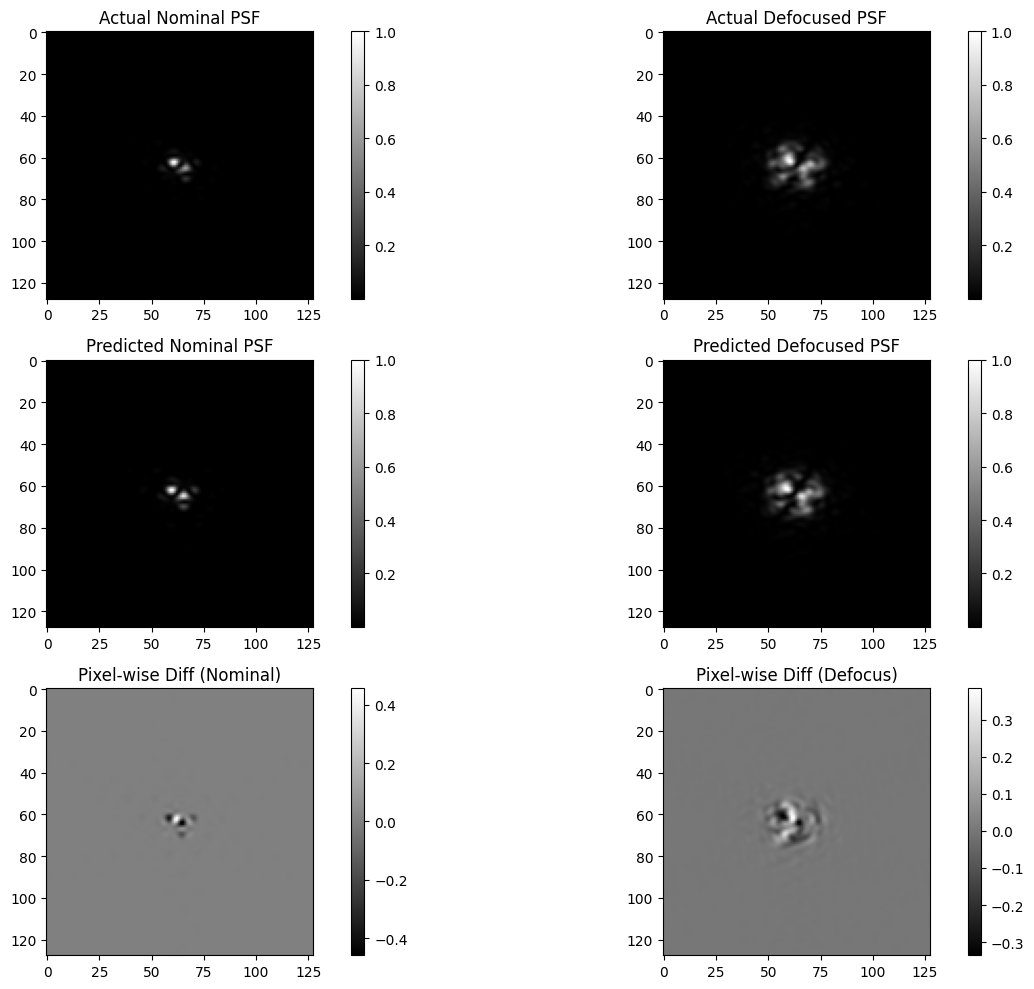

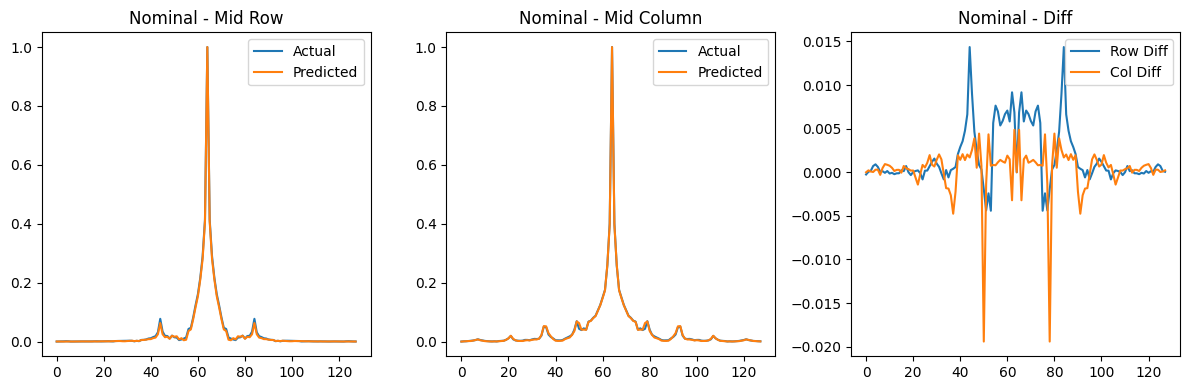

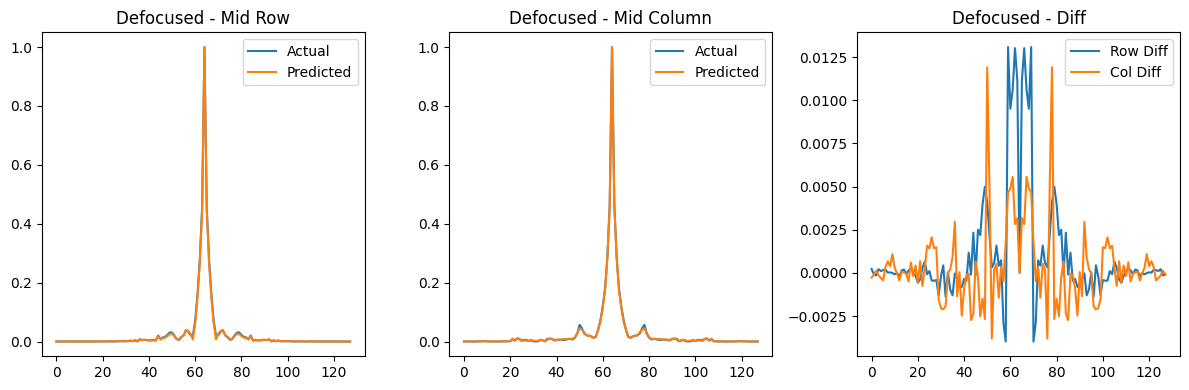

In [78]:
# Example test piston input (in lambda)
input_dict = {"primary_1_piston": -0.2367,
             "primary_2_piston": -0.2324,
             "primary_3_piston": 0.156,
             "primary_4_piston": -0.2040,
             "primary_5_piston": 0.1763,
             "primary_6_piston": -0.166}

result = predict_ptt_from_model(model, ln, config, input_dict, device)